We consider a simple fluid of particles that interact due to the Lennard Jones potential

$$
U(r) = 4\varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

To validate the integration of the diffusion process and correct implementation of energies and forces, we compare observables to results from the literature. The observables are: the mean potential energy of the system per particle $U$,  the pressure $P$ and the radial distribution function $g(r)$.

The thermodynamic quantities of a Lennard Jones fluid are typically expressed in terms of the rescaled density
$\rho^* = (N/V)\sigma^3$ and the rescaled temperature $T^* = k_BT/\varepsilon$, where $N$ is the number of particles in the system, which is constant over time, and $V$ is the available volume.
In simulation practice we set $\sigma=1$ and $\varepsilon=1$ to achieve the reduced units. The quantity $\sigma^2 / 4D$ gives rise to a typical time scale, where $D$ is the self diffusion coefficient of the particles. In practice we set the diffusion coefficient to 1.

We use an Euler-Maruyama scheme to integrate the positions of particles according to the overdamped Langevin equation of motion, in contrast to an integration of positions and momenta in the underdamped limit.

The pressure can be measured from the acting forces according to [4]

$$
PV = Nk_BT + \langle \mathscr{W} \rangle
$$

where

$$
\mathscr{W} = \frac{1}{3} \sum_i \sum_{j>i} \mathbf{r}_{ij} \mathbf{f}_{ij},
$$

is the virial that describes the deviation from ideal-gas-behavior. It is measured in terms of pairwise acting forces $\mathbf{f}_{ij}$ between particles $i$ and $j$ which are separated by $\mathbf{r}_{ij}$. This is implemented by ReaDDy's pressure observable.

__Results__

| origin | cutoff radius $r_c$ | density $\rho$ | temperature $T$ | pressure $P$ | potential energy per particle $U$ |
|---|---|---|---|---|---|
|[1]|4|0.3|3|1.023(2)|-1.673(2)|
|[2]|4|0.3|3|1.0245|-1.6717|
|HALMD [3]|4|0.3|3|1.0234(3)|-1.6731(4)|
|ReaDDy|4|0.3|3|1.035(7)|-1.679(3)|
|||||||
|[1]|4|0.6|3|3.69(1)|-3.212(3)|
|[2]|4|0.6|3|3.7165|-3.2065|
|HALMD [3]|4|0.6|3|3.6976(8)|-3.2121(2)|
|ReaDDy|4|0.6|3|3.70(2)|-3.208(7)|

[1] Molecular dynamics simulations, J. K. Johnson, J. A. Zollweg, and K. E. Gubbins,
The Lennard-Jones equation of state revisited, Mol. Phys. 78, 591 (1993)

[2] Integral equations theory, A. Ayadim, M. Oettel, and S Amokrane,
Optimum free energy in the reference functional approach for the integral equations theory, J. Phys.: Condens. Matter 21, 115103 (2009).

[3] HAL's MD package, http://halmd.org/validation.html

[4] Allen, M. P., & Tildesley, D. J. (1987). Computer Simulation of Liquids. New York: Oxford University Press.

In [1]:
import os
import numpy as np

import readdy
print(readdy.__version__)

v2.0.2-103


Utility methods

In [2]:
def average_across_first_axis(values):
    n_values = len(values)
    mean = np.sum(values, axis=0) / n_values  # shape = n_bins
    difference = values - mean  # broadcasting starts with last axis
    std_dev = np.sqrt(np.sum(difference * difference, axis=0) / n_values)
    std_err = np.sqrt(np.sum(difference * difference, axis=0) / n_values ** 2)
    return mean, std_dev, std_err


def lj_system(edge_length, temperature=1.):
    system = readdy.ReactionDiffusionSystem(
        box_size=[edge_length, edge_length, edge_length],
        unit_system=None
    )
    system.kbt = temperature
    system.add_species("A", diffusion_constant=1.)
    system.potentials.add_lennard_jones("A", "A", m=12, n=6, epsilon=1., sigma=1., cutoff=4., shift=True)
    return system

Wrap the whole simulation and analysis in a function and perform it for the two densities 0.3 and 0.6.

In [3]:
def equilibrate_and_measure(density=0.3):
    n_per_axis = 12
    n_particles = n_per_axis ** 3
    edge_length = (n_particles / density) ** (1. / 3.)
    pos_x = np.linspace(-edge_length/2., edge_length/2.-1., n_per_axis)
    pos = []
    for x in pos_x:
        for y in pos_x:
            for z in pos_x:
                pos.append([x,y,z])
    pos = np.array(pos)
    print("n_particles", len(pos), "box edge_length", edge_length)
    assert len(pos)==n_particles
    
    def pos_callback(x):
        nonlocal pos
        n = len(x)
        pos = np.zeros((n,3))
        for i in range(n):
            pos[i][0] = x[i][0]
            pos[i][1] = x[i][1]
            pos[i][2] = x[i][2]
        print("saved positions")
    
    # create system
    system = lj_system(edge_length, temperature=3.)
    
    # equilibrate
    sim = system.simulation(kernel="CPU")
    sim.add_particles("A", pos)

    sim.observe.particle_positions(2000, callback=pos_callback, save=None)
    sim.observe.energy(500, callback=lambda x: print(x), save=None)

    sim.record_trajectory(stride=1)
    sim.output_file = "lj_eq.h5"
    if os.path.exists(sim.output_file):
        os.remove(sim.output_file)

    sim.run(n_steps=10000, timestep=1e-4)

    traj = readdy.Trajectory(sim.output_file)
    traj.convert_to_xyz(particle_radii={"A": 0.5})
    
    # measure
    sim = system.simulation(kernel="CPU")
    sim.add_particles("A", pos)
    sim.observe.energy(200)
    sim.observe.pressure(200)
    sim.observe.rdf(
        200, bin_borders=np.linspace(0.5, 4., 50),
        types_count_from="A", types_count_to="A", particle_to_density=density)

    sim.output_file = "lj_measure.h5"
    if os.path.exists(sim.output_file):
        os.remove(sim.output_file)

    sim.run(n_steps=10000, timestep=1e-4)
    
    # obtain results
    traj = readdy.Trajectory(sim.output_file)
    _, energy = traj.read_observable_energy()
    _, bin_centers, rdf = traj.read_observable_rdf()
    _, pressure = traj.read_observable_pressure()
    
    energy_mean, _, energy_err = average_across_first_axis(energy) # time average
    energy_mean /= n_particles
    energy_err /= n_particles

    pressure_mean, _, pressure_err = average_across_first_axis(pressure) # time average

    rdf_mean, _, rdf_err = average_across_first_axis(rdf) # time average

    return {
        "energy_mean": energy_mean, "energy_err": energy_err,
        "pressure_mean": pressure_mean, "pressure_err": pressure_err,
        "rdf_mean": rdf_mean, "rdf_err": rdf_err, "rdf_bin_centers": bin_centers
    }

In [ ]:
result_low_dens = equilibrate_and_measure(density=0.3)

In [5]:
result_low_dens

{'energy_mean': -1.6633748459442572,
 'energy_err': 0.003700932686850724,
 'pressure_mean': 1.0180387240087916,
 'pressure_err': 0.006649187919330464,
 'rdf_mean': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.73771465e-04, 1.39050761e-01, 7.77121707e-01, 1.35550697e+00,
        1.47394443e+00, 1.40574566e+00, 1.28072743e+00, 1.17403174e+00,
        1.09877314e+00, 1.04211586e+00, 1.00661263e+00, 9.69183397e-01,
        9.56833466e-01, 9.55143798e-01, 9.59051739e-01, 9.63753456e-01,
        9.75949419e-01, 9.88910358e-01, 1.01500161e+00, 1.01482771e+00,
        1.01116499e+00, 1.00857361e+00, 1.01259469e+00, 1.00827253e+00,
        1.00810550e+00, 1.00061586e+00, 1.00449665e+00, 1.00104653e+00,
        9.98569960e-01, 1.00111624e+00, 9.99901194e-01, 1.00192471e+00,
        1.00256785e+00, 9.96061189e-01, 1.00175797e+00, 9.98210922e-01,
        1.00212448e+00, 9.97903933e-01, 1.00252626e+00, 9.97402108e-01,
        9.99352217e-01, 1.00306833e+00, 1.004

In [ ]:
result_hi_dens = equilibrate_and_measure(density=0.6)

In [7]:
result_hi_dens

{'energy_mean': -3.196356019125088,
 'energy_err': 0.005104397290158243,
 'pressure_mean': 3.7676811569266397,
 'pressure_err': 0.016351902602610355,
 'rdf_mean': array([0.        , 0.        , 0.        , 0.        , 0.0025589 ,
        0.21776871, 1.10357986, 1.72461953, 1.72278639, 1.50528089,
        1.28779136, 1.12018195, 1.00522172, 0.9256746 , 0.88286723,
        0.85705591, 0.86490041, 0.88784101, 0.92720019, 0.97757109,
        1.02364833, 1.05275071, 1.06584753, 1.05618891, 1.04527277,
        1.02953571, 1.00498551, 0.98527115, 0.98062792, 0.97275726,
        0.97639494, 0.98442037, 0.98816345, 0.99719895, 1.0057899 ,
        1.01017784, 1.01483666, 1.01094614, 1.00672468, 1.002867  ,
        0.99891791, 0.99768625, 0.99587933, 0.99519994, 0.99237075,
        0.99940666, 0.99912237, 0.99836934, 1.00126852]),
 'rdf_err': array([0.        , 0.        , 0.        , 0.        , 0.00035327,
        0.00307937, 0.00598724, 0.00770554, 0.00632459, 0.00657016,
        0.00504308, 0

density 0.3:
mean energy per particle -1.6633748459442572
err energy per particle 0.003700932686850724
pressure 1.0180387240087916
err pressure 0.006649187919330464
density 0.6:
mean energy per particle -3.196356019125088
err energy per particle 0.005104397290158243
pressure 3.7676811569266397
err pressure 0.016351902602610355


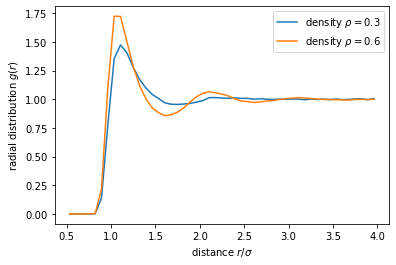

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

print("density 0.3:")
print("mean energy per particle {}\nerr energy per particle {}".format(
    result_low_dens["energy_mean"], result_low_dens["energy_err"]))
print("pressure {}\nerr pressure {}".format(
    result_low_dens["pressure_mean"], result_low_dens["pressure_err"]))
print("density 0.6:")
print("mean energy per particle {}\nerr energy per particle {}".format(
    result_hi_dens["energy_mean"], result_hi_dens["energy_err"]))
print("pressure {}\nerr pressure {}".format(
    result_hi_dens["pressure_mean"], result_hi_dens["pressure_err"]))

plt.plot(result_low_dens["rdf_bin_centers"], result_low_dens["rdf_mean"], label=r"density $\rho=0.3$")
plt.plot(result_hi_dens["rdf_bin_centers"], result_hi_dens["rdf_mean"], label=r"density $\rho=0.6$")
plt.xlabel(r"distance $r/\sigma$")
plt.ylabel(r"radial distribution $g(r)$")
plt.legend(loc="best")
plt.show()